### Solve $Ax = b$

In [1]:
import numpy as np 
import scipy.sparse as sp
import matplotlib.pyplot as plt

A = np.array([[1,2,3],[0,4,5],[0,0,7]])
b = np.array([10,11,12])

## 1D

In [2]:
x = np.linalg.solve(A,b)
assert np.allclose(A@x,b)
print(x)

[3.64285714 0.60714286 1.71428571]


## 2D

In [3]:
b3 = np.array([[10,10,10],[11,11,11],[12,12,12]])
# axis 0
x = np.linalg.solve(A,b3)
assert np.allclose(A@x,b3)

# axis 1
x = np.linalg.solve(A,b3.T)
print(x)
assert np.allclose(x.T@A.T,b3)

[[4.28571429 4.71428571 5.14285714]
 [0.71428571 0.78571429 0.85714286]
 [1.42857143 1.57142857 1.71428571]]


In [4]:
class MatrixBase():
    ''' 
    Store Scalars/Matrices and Information along which axis they
    should be multiplied.
    
    Input
        A: scalar or ndarray
        axis: int
            Defines along which axis PM should be applied
        
    '''
    scalar = False
    def __init__(self,A,axis=0,sparse=False):
        self.sparse = sparse
        self.axis = axis
        
        # Input is a scalar
        if isinstance(A,float) or isinstance(A,int):
            self.A = float(A)
            self.scalar=True
            
        # Input is a Matrix
        elif not sp.issparse(A) and sparse:
            self.A = sp.csr_matrix(A)
        elif sp.issparse(A) and not sparse:
            self.A = self.A.toarray()
        else:
            self.A = A
            
        
        # Store Transpose if axis ==1
        if self.axis==1 and not self.scalar:
            if self.sparse:
                self.AT = sp.csr_matrix(
                    self.A.toarray().T)
            else:
                self.AT = self.A.T
                
        # Define matrix multiplication
        if self.scalar:
            self.dot = self.dot_sc
        else:
            self.dot = self.dot_mm
            
            
    def dot_mm(self,b):
        if self.axis==0:
            return self.A@b
        else:
            return b@self.AT
        
    def dot_sc(self,b):
        return self.A*b
    
class MatrixRHS(MatrixBase):
    def __init__(self,A,axis=0):
        MatrixBase.__init__(self,A,axis,sparse=True)            
                
        
class RHSExplicit():
    '''
    Class handles rhs (b) of the system of equations:
        Ax = b
    or
        Ax = PM@b
    when premultiply is specified
        
    Input:
        b: ndarray (ndim)
            Add rhs part b. More b's can be added by self.add(b).
        premultiply: MatrixBase (optional) 
            Premultiply rhs at each step with sparse Matrix or scalar.
            More can be added via self.add_PM(PM).
    
    Use:
        >>> b = np.array([1,2,3])
        >>> P = np.array([[1,2,3],[4,5,6],[7,8,9]])
        >>> PM = MatrixRHS(P,axis=0)
        >>> R = RHSExplicit(b)
        >>> R.add_PM(PM)
        >>> R.rhs
        >>> array([14, 32, 50]) # = P@b
    '''
    def __init__(self,b,premultiply=None):
        self._b = b
        self.ndim = b.ndim
        self.PM = []
        if premultiply is not None:
            self.add_PM(premultiply)
            
    @property    
    def b(self):
        return self._b
    
    @b.setter
    def b(self,value):
        self._b = value
        
    def add(self, b):
        assert b.ndim == self.ndim
        self.b += b
    
    def add_PM(self,PM):
        assert isinstance(PM,MatrixBase), "PM must be instance Matrixbase"
        assert PM.sparse, "PM must be sparse"
        self.PM.append(PM)
    
    @property
    def rhs(self):
        if self.PM:
            x = self.b
            for P in self.PM:
                x = P.dot(x)
            return x 
        return self.b


In [5]:
b = np.array([1,2,3])

P = np.array([[1,2,3],[4,5,6],[7,8,9]])

PM = MatrixRHS(P,axis=0)
R = RHSExplicit(b)
R.add_PM(PM)
R.rhs

assert np.allclose(R.rhs,P@b)
P@b

array([14, 32, 50])

In [20]:
from scipy.linalg import solve_triangular as sp_triangular
from pypde.solver.fortran import linalg as lafort

class MatrixLHS(MatrixBase):
    '''
    Extends MatrixBase and adds functionality to solve
        Ax = b
    where the type of solver should be chosen by the 
    type of matrix A.
    
    Input:
        See MatrixBase
        
        ndim: int
            Dimensionality of rhs b
            
        axis: int
            Axis along which A should act on b
        
        solver: str (default='solve')
            'solve' : General solver np.linalg.solver(A,b)
            'diag'  :  A is filled only on the main diagonal
            'uptria':  A is upper triangular
            'uptria2': A is upper triangular with 1 lower
                subdiagonal shifted by 2. Arising in HelmholtzProblem
            
    '''
    all_methods = [
        "solve",
        "uptria",
    ]
    def __init__(self,A,ndim,axis,sparse=False,solver="solve"):
        MatrixBase.__init__(self,A,axis,sparse=sparse)
        self.solver = solver
        self.ndim = ndim
        self.set_subsolver()
        
        assert solver in self.all_methods, "Solver type not found!"
        if solver in ["solve"]:
            self.solve = self.solver_solve
        if solver in ["uptria"]:
            self.solve = self.solve_uptria
        

    def solver_solve(self,b):
        assert self.ndim == b.ndim, "Dimensionality mismatch in MatrixLHS. Check ndim."
        if self.axis==0:
            return np.linalg.solve(self.A,b)
        elif self.axis==1:
            assert b.ndim > 1
            return np.linalg.solve(self.A,b.T)
        
    def solve_uptria(self,b):
        #solve_triangular = sp_triangular
            
        if self.axis==0:
            return self._triangular(self.A, b)
        if self.axis==1:
            assert b.ndim > 1
            return self._triangular(self.A, b.T)
        
    def set_subsolver(self):
        if self.ndim==1:
            self._triangular = lafort.triangular.solve_1d
        elif self.ndim == 2:
            self._triangular = lafort.triangular.solve_2d
        
        
class LHSImplicit():
    '''
    Class handles lhs (A) of the system of equations:
        Ax = b
    and defines which strategy should be used to solve
    the system of equations.
    
    Input
        A: MatrixLHS (optional) 
            Contains lhs matrices and information about the solver strategy.
            Additional lhs' can be added using LHSImplicit.add(A)
    
    Use
        >>> A = np.array([[1,2,3],[0,4,5],[0,0,7]])
        >>> b = np.array([[10,10,10],[11,11,11],[12,12,12]])
        >>> MA = MatrixLHS(A,ndim=2,axis=0,solver="uptria")
        >>> L = LHSImplicit(MA)
        >>> L.solve(b)
        >>> assert np.allclose(x,np.linalg.solve(A,b))
    '''
    
    def __init__(self,A=None):
        self.A = []
        if A is not None:
            self.add(A)
        
    def add(self,A):
        assert isinstance(A,MatrixLHS), "PM must be instance MatrixLHS"
        self.A.append(A)
        
    def solve(self,b):
        if self.A:
            for a in self.A:
                b = a.solve(b)
        return b
        

In [25]:
A = np.array([[1,2,3],[0,4,5],[0,0,7]])
b = np.array([10,11,12])
b = np.array([[10,10,10],[11,11,11],[12,12,12]])

MA = MatrixLHS(A,ndim=2,axis=0,solver="uptria")
L = LHSImplicit(MA)
x = L.solve(b)
assert np.allclose(x,np.linalg.solve(A,b))
#np.linalg.solve(A,b)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pypde.field import Field
from pypde.utils.memoize import memoized
from pypde.bases.chebyshev import Chebyshev, ChebDirichlet
from pypde.solver.matrix import *
from pypde.solver.operator import *
from pypde.solver.base import SolverBase
        
class Diffusion1D(SolverBase):
    CONFIG={
        "N": 50,
        "kappa": 1.0,
        "tsave": 0.01,
        "dt": 0.2,
        "ndim": 1,
    }
    def __init__(self,**kwargs):
        SolverBase.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.update_config(**kwargs)
        
        
        self.field = Field(self.N)   # Field variable
        self.time = 0.0              # Time
        self.xf = ChebDirichlet(self.N+2,bc=(0,0))   # Basis in x
        self.x  = self.xf.x          # X-coordinates
    
    @property
    def v(self):
        '''  Main variable (dv/dt) '''
        return self.field.v
    
    @v.setter
    def v(self,value):
        self.field.v = value
        
    @property
    @memoized
    def LHS(self):
        '''
        (I-alpha*dt*D2) u = rhs
        '''
        D2 = self.xf.stiff.toarray()
        M  = self.xf.mass.toarray()
        A = M - self.dt*(self.kappa*D2)
        A = MatrixLHS(A,ndim=self.ndim,axis=0,solver="uptria2")
        return LHSImplicit(A)
    
    @property
    @memoized
    def RHS(self):
        '''
        lhs = dt*f + u
        only dt*f is stored initially, u is updated in update()
        '''
        M  = self.xf.mass.toarray()
        fhat = self.dt*self.xf.forward_fft(self._f())
        
        b = RHSExplicit(f=fhat)
        b.add_PM(MatrixRHS(M,axis=0))
        return b
        
    def _f(self):
        ''' Forcing Functions'''
        return np.cos(1*np.pi/2*self.x)
        
        
    def update_config(self,**kwargs):
        self.__dict__.update(**kwargs)
        
    def set_bc(self):
        self.v[ [-2,-1] ] = 0.0
        
    def update(self):
        ''' 
        Update pde by 1 timestep 
        '''
        self.set_bc()
        self.RHS.b = self.v
        self.v = self.LHS.solve(self.RHS.rhs)
        self.update_time()
        


Time: 0.100
Time: 0.200
Time: 0.300
Time: 0.400
Time: 0.500
Time: 0.600
Time: 0.700
Time: 0.800
Time: 0.900
Time: 1.000
Time: 1.100
Save animation to out/anim.mp4


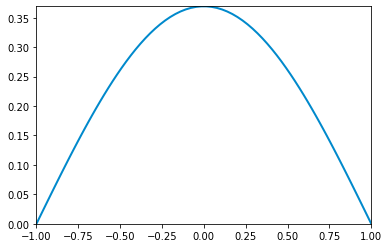

In [6]:
D = Diffusion1D(N=100,dt=0.1,tsave=0.1)
#D.update()

D.iterate(1)
# # Transfer stored fields to real space
for i,vv in enumerate(D.field.V):
    D.field.V[i] = D.xf.backward_fft(vv)

anim = D.field.animate(D.x,duration=4)
plt.show()

array([[ 1.900e+00,  0.000e+00, -1.000e-01, ...,  0.000e+00,  4.000e-01,
         0.000e+00],
       [ 0.000e+00,  2.200e+00,  0.000e+00, ...,  8.000e-01,  0.000e+00,
         8.000e-01],
       [-5.000e-01,  0.000e+00,  3.400e+00, ...,  0.000e+00,  1.200e+00,
         0.000e+00],
       ...,
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  4.714e+02,  0.000e+00,
         1.870e+01],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  4.910e+02,
         0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ..., -5.000e-01,  0.000e+00,
         5.115e+02]])

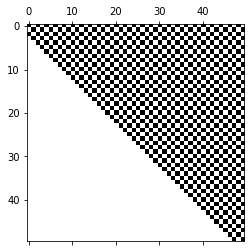

In [3]:
plt.spy(D.LHS.A[0].A)
D.LHS.A[0].A

In [18]:
import numpy as np 
import matplotlib.pyplot as plt
from pypde.field import Field
from pypde.utils.memoize import memoized
from pypde.bases.chebyshev import Chebyshev, ChebDirichlet
from pypde.solver.matrix import *
from pypde.solver.operator import *
from pypde.solver.base import SolverBase

class Diffusion2D(SolverBase):
    CONFIG={
        "N": 50,
        "kappa": 1.0,
        "tsave": 0.01,
        "dt": 0.2,
        "ndim": 2,
    }
    def __init__(self,**kwargs):
        SolverBase.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.update_config(**kwargs)
        
        shape = (self.N,self.N)
        self.field = Field(shape)   # Field variable
        self.time = 0.0              # Time
        self.xf = ChebDirichlet(self.N+2,bc=(0,0))   # Basis in x
        self.x  = self.xf.x          # X-coordinates
    
    @property
    def v(self):
        '''  Main variable (dv/dt) '''
        return self.field.v
    
    @v.setter
    def v(self,value):
        self.field.v = value
        
    @property
    @memoized
    def LHS(self):
        '''
        (I-alpha*dt*D2) u = rhs
        '''
        D2 = self.xf.stiff.toarray()
        M  = self.xf.mass.toarray()
        A = M - self.dt*(self.kappa*D2)
        A1 = MatrixLHS(A,ndim=self.ndim,axis=0,solver="uptria2")
        LHS = LHSImplicit(A1)
        A2 = MatrixLHS(A,ndim=self.ndim,axis=1,solver="uptria2")
        LHS.add(A2)
        return LHS
    
    @property
    @memoized
    def RHS(self):
        '''
        lhs = dt*f + u
        only dt*f is stored initially, u is updated in update()
        '''
        M  = self.xf.mass.toarray()
        fhat = self._f()
        fhat = self.xf.forward_fft(self._f())
        fhat = self.xf.forward_fft(fhat.T).T
        fhat *= self.dt
        
        b = RHSExplicit(f=fhat)
        b.add_PM(MatrixRHS(M,axis=0))
        b.add_PM(MatrixRHS(M,axis=1))
        return b
        
    def _f(self):
        ''' Forcing Functions'''
        xx,yy = np.meshgrid(self.x,self.x)
        return np.cos(1*np.pi/2*xx)*np.cos(1*np.pi/2*yy)
        
    def update_config(self,**kwargs):
        self.__dict__.update(**kwargs)
        
    def set_bc(self):
        self.v[ [-2,-1] ] = 0.0
        
    def update(self):
        ''' 
        Update pde by 1 timestep 
        '''
        self.set_bc()
        self.RHS.b = self.v
        self.v = self.LHS.solve(self.RHS.rhs)
        self.update_time()
        

In [19]:
%%time

D = Diffusion2D(N=600,dt=0.001,tsave=0.05)
D.update()
D.iterate(1.0)

Time: 0.050
Time: 0.100
Time: 0.150
Time: 0.200
Time: 0.250
Time: 0.300
Time: 0.350
Time: 0.400
Time: 0.450
Time: 0.500
Time: 0.550
Time: 0.600
Time: 0.650
Time: 0.700
Time: 0.750
Time: 0.800
Time: 0.850
Time: 0.900
Time: 0.950
Time: 1.000
CPU times: user 2min 1s, sys: 536 ms, total: 2min 2s
Wall time: 2min 1s


In [17]:
%%time

D = Diffusion2D(N=600,dt=0.001,tsave=0.05)
D.update()
D.iterate(1.0)
#print(D.v)

Time: 0.050
Time: 0.100
Time: 0.150
Time: 0.200
Time: 0.250
Time: 0.300
Time: 0.350
Time: 0.400
Time: 0.450
Time: 0.500
Time: 0.550
Time: 0.600
Time: 0.650
Time: 0.700
Time: 0.750
Time: 0.800
Time: 0.850
Time: 0.900
Time: 0.950
Time: 1.000
CPU times: user 3min 15s, sys: 42 s, total: 3min 57s
Wall time: 1min 6s


Save animation to out/anim.mp4


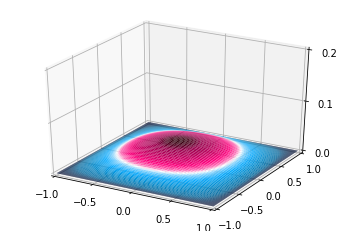

In [3]:
# # Transfer stored fields to real space
for i,vv in enumerate(D.field.V):
    D1 = D.xf.backward_fft(vv)
    D.field.V[i] = D.xf.backward_fft(D1.T).T

anim = D.field.animate(D.x,duration=4)
plt.show()